Improvements over binary classifier:

- removed unused graphviz import
- define labels to classify: simply encode (no) vandalism according to a set of labels
- use features computed by rev 5f03bf5 of the vandalism detector, includes revision ID
- use DataFrame - it works the same and retains column labels etc.
- added plt.show() to error analysis to draw matrix
- add example FP and FN (= misclassified revisions)
- added plot for FP frequency per tag


In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import HTML, display

In [181]:
np.random.seed(4222968274)

In [182]:
# Import dataset
df = pd.read_csv('./data/features-total-80c4772.csv')
tag_df = pd.read_csv('./data/tag.csv')
labels = df.columns
df.head()

,isContributorAnonymous,isBot,timeOfDay,dayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,timeSinceFirstArticleEditBySameContributor,revertCount,...,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,revision_id,tag_id
0,0.0,0.0,13.0,7.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,...,11910.000000,0.513889,1024.000000,34.0,0.0,0.0,0.0,0.0,228189784,12
1,0.0,0.0,2.0,2.0,0.0,1.0,25.0,25.0,198701.0,0.0,...,0.003832,0.308994,4.126739,14.0,0.0,0.0,0.0,0.0,730449352,12
2,0.0,0.0,17.0,6.0,1.0,0.0,7837.0,-1.0,-1.0,0.0,...,0.003622,0.434896,85.525822,67.0,0.0,0.0,2.0,0.0,216224416,12
3,0.0,1.0,1.0,4.0,1.0,0.0,2108.0,-1.0,-1.0,0.0,...,-0.000196,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,539338621,12
4,1.0,0.0,20.0,2.0,0.0,0.0,4077.0,-1.0,-1.0,0.0,...,0.000048,0.428264,342.595182,10.0,0.0,0.0,0.0,0.0,746191686,12


In [183]:
# Select only non-baseline features
baseline_features = [
    'revision_id',
    'tag_id',
    # Context
    'isContributorAnonymous',
    'commentLength',
    'sizeChange',
    'timeSinceLastArticleEdit',
    'timeOfDay',
    'dayOfWeek',
    'timeSinceFirstArticleEditBySameContributor',
    'timeSinceContributorRevertedBeforeInThatArticle',
    'sizeRatio',
    'hasPreviousSameContributor',
    # Text
    'ratioOfNumericalCharsToAllChars',
    'ratioOfAlphanumericCharsToAllChars',
    'ratioOfUppercaseCharsToAllChars',
    'ratioOfUppercaseCharsToLowercaseChars',
    'lengthOfLongestConsecutiveSequenceOfSingleChar',
    'lengthOfLongestToken',
    'averageRelativeFrequencyOfNewAddedWords',
    'LZWCompressionRate',
    'KLDOfCharDistribution',
    'previousLength',
    # Language
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    # Ref: Colloquial, high bias
    'superlativeWordFrequencyInComment',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'averageAllBadWordFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    # Ref: Good words
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'revertInComment'
]

df = df[baseline_features]
df.head()

,revision_id,tag_id,isContributorAnonymous,commentLength,sizeChange,timeSinceLastArticleEdit,timeOfDay,dayOfWeek,timeSinceFirstArticleEditBySameContributor,timeSinceContributorRevertedBeforeInThatArticle,...,sexualWordFrequencyInComment,sexualWordFrequencyInTables,sexualWordImpactInTables,averageAllBadWordFrequencyInComment,averageAllBadWordFrequencyInTable,averageAllBadWordImpactInTable,wikiSyntaxElementFrequencyInTable,wikiSyntaxElementImpactInTable,wikiSyntaxElementFrequencyInComment,revertInComment
0,228189784,12,0.0,34.0,11909.0,-1.0,13.0,7.0,-1.0,-1.0,...,0.0,0.0,0.0,0.080000,0.140373,22.600000,0.315789,24.000000,0.0,0.0
1,730449352,12,0.0,14.0,504.0,25.0,2.0,2.0,198701.0,57386.0,...,0.0,0.0,0.0,0.000000,0.000000,-0.024631,0.200000,-0.029851,0.0,1.0
2,216224416,12,0.0,67.0,78.0,7837.0,17.0,6.0,-1.0,-1.0,...,0.0,0.0,0.0,0.133333,0.088889,0.103846,0.000000,0.000000,0.0,0.0
3,539338621,12,0.0,152.0,-14.0,2108.0,1.0,4.0,-1.0,-1.0,...,0.0,0.0,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,746191686,12,1.0,10.0,0.0,4077.0,20.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.000000,0.000000,-0.000851,0.000000,0.000000,0.0,0.0


In [184]:
# Encode vandalism or no vandalism according to tags-of-interest
TAG_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
df['is_vandalism'] = df.tag_id.isin(TAG_IDS)
tag_df

,id,name
0,1,Blanking
1,2,Nonsense
2,3,QualityIssue
3,4,PersonalStory
4,5,FalseFacts
5,6,Syntax
6,7,MergeConflict
7,8,Template
8,9,EditWars
9,10,SEO


In [185]:
X = df
y = df['is_vandalism']
labels = X.columns

In [186]:
# Undersample class of 'constructive' samples
sampler = RandomUnderSampler()
X_resampled, y_resampled = sampler.fit_sample(X, y)

# Convert sampler output to DF - rescue column names etc.
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Split dataset into training and test
X_train_complete, X_test_complete, y_train, y_test = train_test_split(X_resampled, y_resampled)

# Truncate metadata columns
feature_columns = [x for x in X.columns if x not in ['is_vandalism', 'tag_id', 'revision_id']]
X_train = X_train_complete[feature_columns]
X_test = X_test_complete[feature_columns]

print('Train X', X_train.shape)
print('Train y', y_train.shape)

print('Test X', X_test.shape)
print('Test y', y_test.shape)

Train X (3709, 39)
Train y (3709,)
Test X (1237, 39)
Test y (1237,)


In [187]:
# Build model and evaluate parameters using crossvalidation
clf = RandomForestClassifier(class_weight='balanced')

scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=3, return_train_score=False)    

print('Training scores:')
for name, values in scores.items():
    print(name, ": %0.2f (+/- %0.2f)" % (values.mean(), values.std() * 2))

Training scores:
fit_time : 0.06 (+/- 0.01)
score_time : 0.02 (+/- 0.00)
test_f1 : 0.80 (+/- 0.02)
test_precision : 0.82 (+/- 0.03)
test_recall : 0.78 (+/- 0.05)
test_roc_auc : 0.88 (+/- 0.01)
test_accuracy : 0.81 (+/- 0.01)


In [188]:
# Evaluate model parameters: Confusion matrix
columns = ['Predicted No Vandalism', 'Predicted Vandalism']
index = ['True No Vandalism', 'True Vandalism']
classes = ['No Vandalism', 'Vandalism']

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_predict)

print('Training scores:')
pd.DataFrame(cf_matrix, columns=columns, index=index)

Training scores:


,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,1512,330
True Vandalism,387,1480


In [189]:
# Evaluate model parameters: Classification report
print('Training scores:')
print(classification_report(y_train, y_train_predict, target_names=classes))

Training scores:
              precision    recall  f1-score   support

No Vandalism       0.80      0.82      0.81      1842
   Vandalism       0.82      0.79      0.81      1867

 avg / total       0.81      0.81      0.81      3709



In [190]:
# Train model
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
y_predict_prob = clf.predict_proba(X_test)
y_predict_vandalism = y_predict_prob[:,1]

Precision and recall scores:


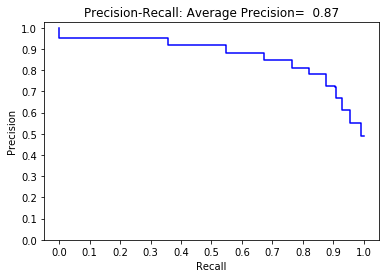

PR-AUC 0.8893546448412759


In [191]:
# Evaluate model: Precision & Recall
print('Precision and recall scores:')

precision, recall, thresholds = precision_recall_curve(y_test, y_predict_vandalism)
average_precision = average_precision_score(y_test, y_predict_vandalism)

plt.title('Precision-Recall: Average Precision=  %0.2f' % average_precision)
plt.step(recall, precision, color='b', where='post')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print("PR-AUC", auc(recall, precision))

In [192]:
# Evaluate model: Confusion matrix
columns = ['Predicted No Vandalism', 'Predicted Vandalism']
index = ['True No Vandalism', 'True Vandalism']

print('Final model scores:')
pd.DataFrame(confusion_matrix(y_test, y_predict), columns=columns, index=index)

Final model scores:


,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,515,116
True Vandalism,108,498


In [193]:
# Evaluate model: Classification report
print('Final model scores:')
print(classification_report(y_test, y_predict, target_names=classes))

Final model scores:
              precision    recall  f1-score   support

No Vandalism       0.83      0.82      0.82       631
   Vandalism       0.81      0.82      0.82       606

 avg / total       0.82      0.82      0.82      1237



Final model scores:
roc_auc 0.8880960600021968


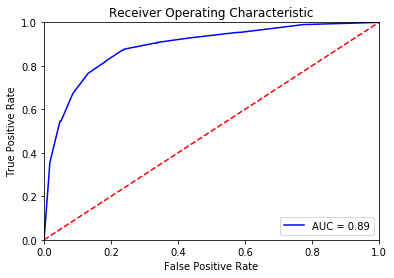

In [194]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_vandalism)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Final model scores:')
print('roc_auc', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

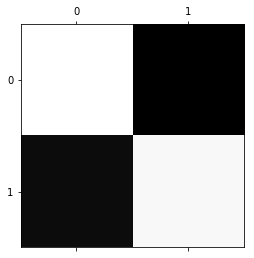

In [195]:
# Error analysis
y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_predict)

plt.matshow(cf_matrix, cmap=plt.cm.gray)
plt.show()

In [196]:
# Showing some instances not classifed correctly

# False Negatives for the test set
fn_test = X_test_complete[(y_test == 1) & (y_predict == 0)]
fn_with_labels = fn_test.merge(tag_df, how='left', left_on='tag_id', right_on='id')
#fn_with_labels[['revision_id', 'tag_id', 'name']]

fn_html = []
for _, item in fn_with_labels.iterrows():
    item_html = """
        {tag}: 
        <a href="http://en.wikipedia.org/index.php?diff={rev_id}">
          {rev_id} 
        </a>
    """.format(rev_id=int(item['revision_id']), tag=item['name'])
    fn_html.append(item_html)
display(HTML(',&nbsp;'.join(fn_html)))

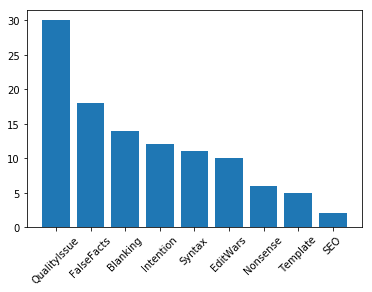

In [197]:
fn_tag_counts = fn_with_labels.name.value_counts()
fn_tag_x = np.arange(len(fn_tag_counts))
plt.bar(fn_tag_x, fn_tag_counts.values)
plt.xticks(fn_tag_x, fn_tag_counts.index, rotation=45)
plt.show()

In [198]:
# False Positives for the test set
fp_test = X_test_complete[(y_test == 0) & (y_predict == 1)]
fp_with_labels = fp_test.merge(tag_df, how='left', left_on='tag_id', right_on='id')
fp_with_labels[['revision_id', 'tag_id', 'name']]

,revision_id,tag_id,name
0,348273744.0,12.0,constructive
1,294226607.0,12.0,constructive
2,273476415.0,12.0,constructive
3,631021594.0,12.0,constructive
4,767530418.0,12.0,constructive
5,195848111.0,12.0,constructive
6,467539977.0,12.0,constructive
7,547258167.0,12.0,constructive
8,443540508.0,12.0,constructive
9,17568638.0,12.0,constructive


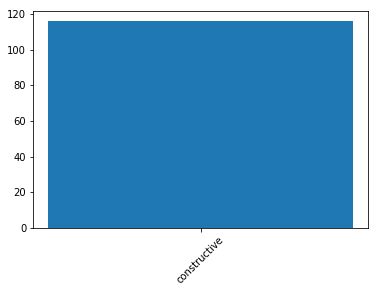

In [199]:
fp_tag_counts = fp_with_labels.name.value_counts()
tag_x = np.arange(len(fp_tag_counts))
plt.bar(tag_x, fp_tag_counts.values)
plt.xticks(tag_x, fp_tag_counts.index, rotation=45)
plt.show()

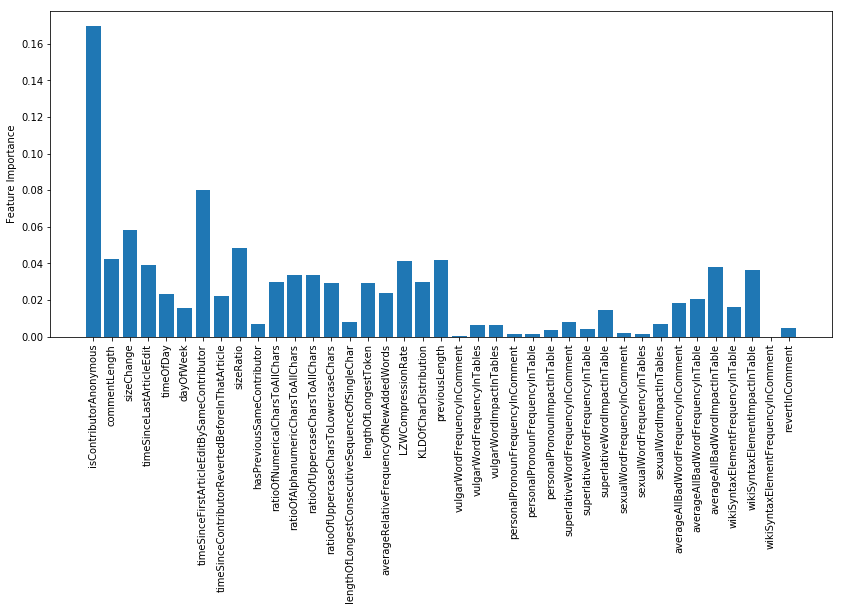

In [200]:
# Feature importance (weights in random forrest)
feature_importance = clf.feature_importances_
feature_labels = X_train.columns
x_pos = np.arange(len(feature_importance)) 

plt.gcf().set_size_inches(14, 6)
plt.bar(x_pos, feature_importance,align='center')
plt.xticks(x_pos, feature_labels, rotation='vertical') 
plt.ylabel('Feature Importance')
plt.show()

In [201]:
feature_importance

array([0.1696592 , 0.04241489, 0.05839602, 0.03915174, 0.02335523,
       0.01554918, 0.08005096, 0.02247726, 0.04861262, 0.00688016,
       0.02987728, 0.03393094, 0.03389113, 0.02950351, 0.00813322,
       0.02914869, 0.0236576 , 0.04123388, 0.02968066, 0.04173309,
       0.00035898, 0.00624813, 0.00653648, 0.00165592, 0.00156955,
       0.00372304, 0.00808579, 0.00441033, 0.01458739, 0.00223819,
       0.00149522, 0.00708721, 0.01836186, 0.02033266, 0.03828098,
       0.01643946, 0.03653943, 0.        , 0.00471212])